# w261 Final Project - Clickthrough Rate Prediction


# Team & Members

Team #21

Brent Biseda  
Katie Mo  
Teddy Fong  
Thanh Le  
Summer 2019, section 4   

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import sys
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
sc = SparkContext(appName="CSV2Parquet")
sqlContext = SQLContext(sc)

In [5]:
def parseIntegerColumns(line):
    row = line.split("\t")
    for i in range(14):
        if row[i] == "":
            row[i] = None
        else:
            row[i] = int(row[i])
    return row

In [6]:
# # Convert train file from csv to parquet
# schema = StructType([
#     StructField("y", IntegerType(), True),
#     StructField("x1", IntegerType(), True),
#     StructField("x2", IntegerType(), True),
#     StructField("x3", IntegerType(), True),
#     StructField("x4", IntegerType(), True),
#     StructField("x5", IntegerType(), True),
#     StructField("x6", IntegerType(), True),
#     StructField("x7", IntegerType(), True),
#     StructField("x8", IntegerType(), True),
#     StructField("x9", IntegerType(), True),
#     StructField("x10", IntegerType(), True),
#     StructField("x11", IntegerType(), True),
#     StructField("x12", IntegerType(), True),
#     StructField("x13", IntegerType(), True),
#     StructField("x14", StringType(), True),
#     StructField("x15", StringType(), True),
#     StructField("x16", StringType(), True),
#     StructField("x17", StringType(), True),
#     StructField("x18", StringType(), True),
#     StructField("x19", StringType(), True),
#     StructField("x20", StringType(), True),
#     StructField("x21", StringType(), True),
#     StructField("x22", StringType(), True),
#     StructField("x23", StringType(), True),
#     StructField("x24", StringType(), True),
#     StructField("x25", StringType(), True),
#     StructField("x26", StringType(), True),
#     StructField("x27", StringType(), True),
#     StructField("x28", StringType(), True),
#     StructField("x29", StringType(), True),
#     StructField("x30", StringType(), True),
#     StructField("x31", StringType(), True),
#     StructField("x32", StringType(), True),
#     StructField("x33", StringType(), True),
#     StructField("x34", StringType(), True),
#     StructField("x35", StringType(), True),
#     StructField("x36", StringType(), True),
#     StructField("x37", StringType(), True),
#     StructField("x38", StringType(), True),
#     StructField("x39", StringType(), True)])
# rdd = sc.textFile('train.txt').map(parseIntegerColumns)
# df = sqlContext.createDataFrame(rdd, schema)
# df.write.parquet('train.parquet')

In [7]:
def parseIntegerColumnsTest(line):
    row = line.split("\t")
    for i in range(13):
        if row[i] == "":
            row[i] = None
        else:
            row[i] = int(row[i])
    return row

In [8]:
# # Convert test file from csv to parquet
# schema = StructType([
#     #StructField("y", IntegerType(), True), # Test Data Does not have y label
#     StructField("x1", IntegerType(), True),
#     StructField("x2", IntegerType(), True),
#     StructField("x3", IntegerType(), True),
#     StructField("x4", IntegerType(), True),
#     StructField("x5", IntegerType(), True),
#     StructField("x6", IntegerType(), True),
#     StructField("x7", IntegerType(), True),
#     StructField("x8", IntegerType(), True),
#     StructField("x9", IntegerType(), True),
#     StructField("x10", IntegerType(), True),
#     StructField("x11", IntegerType(), True),
#     StructField("x12", IntegerType(), True),
#     StructField("x13", IntegerType(), True),
#     StructField("x14", StringType(), True),
#     StructField("x15", StringType(), True),
#     StructField("x16", StringType(), True),
#     StructField("x17", StringType(), True),
#     StructField("x18", StringType(), True),
#     StructField("x19", StringType(), True),
#     StructField("x20", StringType(), True),
#     StructField("x21", StringType(), True),
#     StructField("x22", StringType(), True),
#     StructField("x23", StringType(), True),
#     StructField("x24", StringType(), True),
#     StructField("x25", StringType(), True),
#     StructField("x26", StringType(), True),
#     StructField("x27", StringType(), True),
#     StructField("x28", StringType(), True),
#     StructField("x29", StringType(), True),
#     StructField("x30", StringType(), True),
#     StructField("x31", StringType(), True),
#     StructField("x32", StringType(), True),
#     StructField("x33", StringType(), True),
#     StructField("x34", StringType(), True),
#     StructField("x35", StringType(), True),
#     StructField("x36", StringType(), True),
#     StructField("x37", StringType(), True),
#     StructField("x38", StringType(), True),
#     StructField("x39", StringType(), True)])

# rdd = sc.textFile('test.txt').map(parseIntegerColumnsTest)
# df = sqlContext.createDataFrame(rdd, schema)
# df.write.parquet('test.parquet')

In [9]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_project_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()

In [10]:
spark

In [11]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [12]:
testRDD = sqlContext.read.parquet('test.parquet').rdd # This Loads an RDD
testDF = sqlContext.read.parquet('test.parquet') # This loads a Data Frame

In [13]:
trainRDD = sqlContext.read.parquet('train.parquet').rdd
trainDF = sqlContext.read.parquet('train.parquet')

In [14]:
HEADER = trainDF.columns

In [15]:
sample = trainDF.sample(False, 0.0001, seed=1234).toPandas() # Approximately 5000 records

In [16]:
sample.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39
0,0,NaN,9,5.0,5.0,1543.0,NaN,0.0,5.0,64.0,...,1e88c74f,df4fffb7,21ddcdc9,5840adea,b9fac036,,32c7478e,625964a3,010f6491,aa5f0a15
1,0,NaN,45,4.0,4.0,610.0,31.0,2.0,27.0,31.0,...,07c540c4,d4328054,,,0014c32a,,bcdee96c,3b183c5c,,
2,0,NaN,105,15.0,12.0,103.0,NaN,0.0,29.0,26.0,...,07c540c4,e96a7df2,,,5fe17899,,423fab69,cafb4e4d,,
3,0,NaN,54,94.0,2.0,190275.0,NaN,0.0,2.0,1.0,...,e5ba7672,5aed7436,21ddcdc9,b1252a9d,c2c9ac18,,32c7478e,9bafd547,e8b83407,1bae8608
4,0,NaN,8,8.0,1.0,212127.0,NaN,0.0,3.0,1.0,...,d4bb7bd8,7ef5affa,21ddcdc9,b1252a9d,04507927,,32c7478e,3fdb382b,e8b83407,49d68486


In [17]:
sample.describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
count,4491.000000,2466.000000,4491.000000,3534.000000,3489.000000,4.363000e+03,3466.000000,4293.000000,4486.000000,4293.000000,2466.000000,4293.000000,1080.000000,3489.000000
mean,0.255400,3.461071,100.537297,20.346067,7.420178,1.574706e+04,115.535776,15.942930,12.422202,110.305381,0.589619,2.722106,1.118519,8.292634
std,0.436134,10.332814,367.581495,74.584267,9.411771,5.325080e+04,296.793279,53.564041,13.092811,269.943359,0.691500,5.095305,5.352871,12.421845
min,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.000000,2.000000,3.965000e+02,9.000000,1.000000,2.000000,11.000000,0.000000,1.000000,0.000000,2.000000
50%,0.000000,1.000000,2.000000,6.000000,4.000000,2.823000e+03,35.000000,3.000000,7.000000,39.000000,0.000000,1.000000,0.000000,4.000000
75%,1.000000,3.000000,34.000000,18.000000,9.000000,1.013100e+04,109.750000,10.000000,19.000000,112.000000,1.000000,3.000000,1.000000,10.000000
max,1.000000,299.000000,3933.000000,3203.000000,191.000000,1.056009e+06,8980.000000,1114.000000,117.000000,8445.000000,5.000000,71.000000,76.000000,321.000000


In [18]:
INTEGER_FEATURES = HEADER[0:14] # These are the integer features
CATEGORICAL_FEATURES = HEADER[14:] # These are the categorical features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2a79a88048>,
      dtype=object)

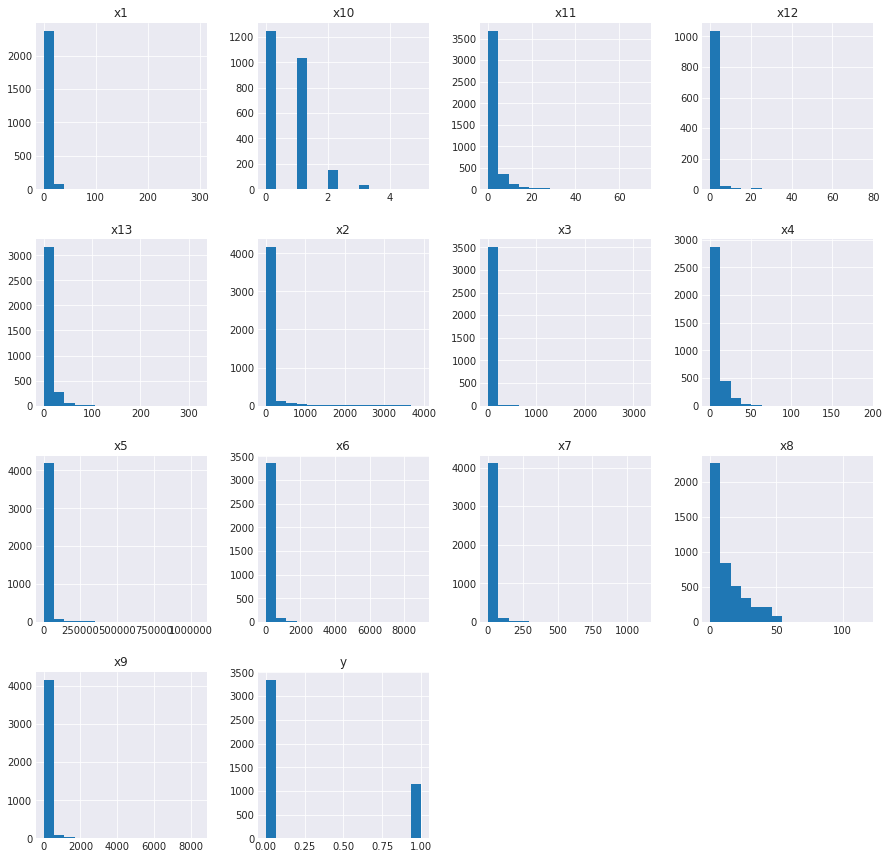

In [19]:
sample[INTEGER_FEATURES].hist(figsize=(15,15), bins=15)

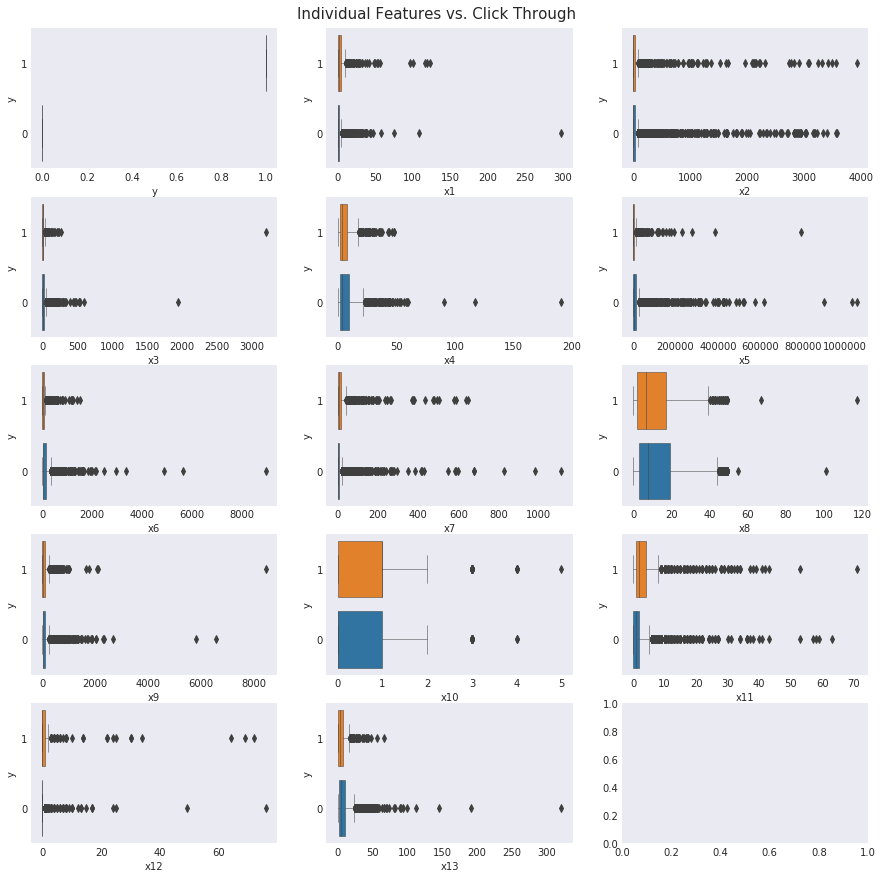

In [20]:
fig, ax_grid = plt.subplots(5, 3, figsize=(15,15))
y = sample['y']
for idx, feature in enumerate(INTEGER_FEATURES):
    x = sample[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Individual Features vs. Click Through", fontsize=15, y=0.9)
plt.show()

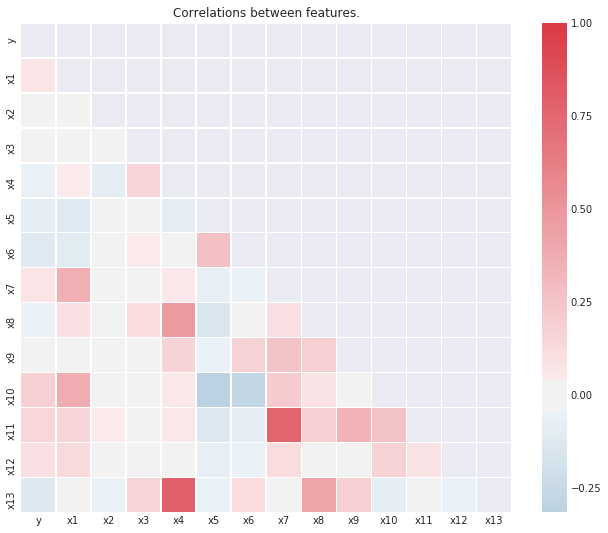

In [21]:
# plot heatmap for correlations matrix - RUN THIS CELL AS IS
corr = sample[INTEGER_FEATURES].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

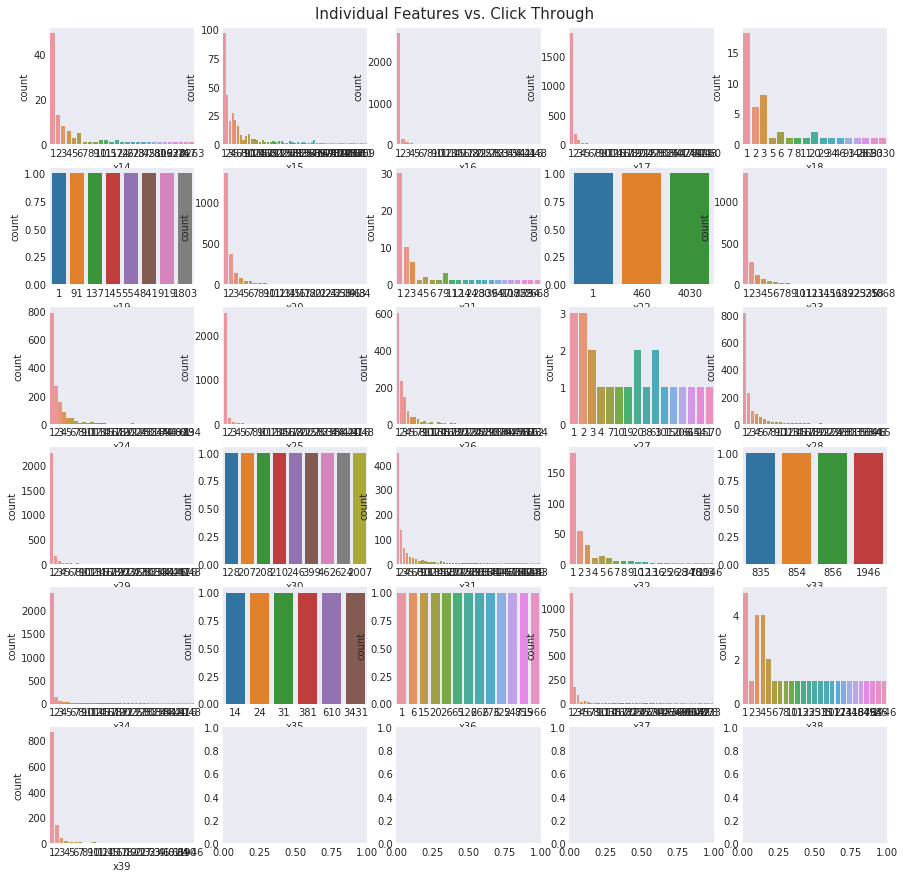

In [22]:
# Categorical Data Visualization
fig, ax_grid = plt.subplots(6, 5, figsize=(15,15))
for idx, feature in enumerate(CATEGORICAL_FEATURES):
    x = sample[feature].astype('category').value_counts()
    sns.countplot(x, ax=ax_grid[idx//5][idx%5], linewidth=.5)
fig.suptitle("Individual Features vs. Click Through", fontsize=15, y=0.9)
plt.show()

# Train and Validation Data Sets

In [19]:
# Generate 80/20 (pseudo)random train/test split 
trainingDF, validDF = trainDF.randomSplit([0.8,0.2], seed = 1)
print(f"... held out {validDF.count()} records for evaluation and assigned {trainingDF.count()} for training.")

... held out 9172331 records for evaluation and assigned 36668286 for training.


# We will need to one hot encode the categorical variables

This article has some detail on doing this.

https://towardsdatascience.com/feature-encoding-with-spark-2-3-0-part-1-9ede45562740  
https://chih-ling-hsu.github.io/2018/09/17/spark-mllib  

# Example of playing around with the RDD pipeline

In [20]:
validDF.take(1)

[Row(y=0, x1=None, x2=-2, x3=None, x4=None, x5=10091, x6=None, x7=0, x8=10, x9=37, x10=None, x11=0, x12=None, x13=None, x14='05db9164', x15='04e09220', x16='99b1c7f1', x17='a1e6a194', x18='43b19349', x19='7e0ccccf', x20='5f3a87ef', x21='1f89b562', x22='a73ee510', x23='74273dde', x24='69efa7ec', x25='dd727b99', x26='99b4a17d', x27='f862f261', x28='33b0f0e1', x29='23056e4f', x30='1e88c74f', x31='e161d23a', x32='', x33='', x34='cf6b91c6', x35='', x36='32c7478e', x37='ded4aac9', x38='', x39='')]

In [21]:
integerTrainingDF = trainingDF[INTEGER_FEATURES]
integerValidDF = validDF[INTEGER_FEATURES]

In [22]:
# integerTrainingDF = integerTrainingDF.dropna()
integerTrainingDF = integerTrainingDF.fillna(0)
integerValidDF = integerValidDF.fillna(0)

In [23]:
integerTrainingDF.take(1)

[Row(y=0, x1=0, x2=-2, x3=0, x4=0, x5=2890, x6=0, x7=0, x8=9, x9=16, x10=0, x11=0, x12=0, x13=0)]

In [24]:
assembler = VectorAssembler(inputCols = INTEGER_FEATURES[1:], outputCol = 'features')
integerVectorTrainDF = assembler.transform(integerTrainingDF)
integerVectorTrainDF = integerVectorTrainDF.select(['features', 'y'])

integerValidDF = assembler.transform(integerValidDF)
integerValidDF = integerValidDF.select(['features', 'y'])

In [25]:
integerVectorTrainDF.take(3)

[Row(features=SparseVector(13, {1: -2.0, 4: 2890.0, 7: 9.0, 8: 16.0}), y=0),
 Row(features=SparseVector(13, {1: -2.0, 4: 4383.0, 7: 18.0, 8: 29.0}), y=0),
 Row(features=SparseVector(13, {1: -2.0, 4: 6387.0, 5: 15.0, 6: 4.0, 7: 14.0, 8: 15.0, 10: 1.0}), y=0)]

### Linear Regression Model

In [58]:
from pyspark.ml.regression import LinearRegression

start = time.time()
lr = LinearRegression(featuresCol = 'features', labelCol='y', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(integerVectorTrainDF)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))
print(f"\n... Executed in {time.time() - start} seconds")

Coefficients: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
Intercept: 0.2562331929013535

... Executed in 472.1147437095642 seconds


In [59]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.436552
r2: 0.000000


In [61]:
predictions = lr_model.transform(integerValidDF)
predictions.select("prediction","y","features").show()

+------------------+---+--------------------+
|        prediction|  y|            features|
+------------------+---+--------------------+
|0.2562331929013535|  0|(13,[1,4,7,8],[-2...|
|0.2562331929013535|  0|(13,[1,4,5,6,7,8,...|
|0.2562331929013535|  0|(13,[1,4],[-2.0,1...|
|0.2562331929013535|  0|(13,[1,3,4,7,8,12...|
|0.2562331929013535|  0|(13,[1,2,4,8],[-2...|
|0.2562331929013535|  0|[0.0,-2.0,1.0,0.0...|
|0.2562331929013535|  0|[0.0,-2.0,1.0,0.0...|
|0.2562331929013535|  0|[0.0,-2.0,1.0,0.0...|
|0.2562331929013535|  0|[0.0,-2.0,1.0,0.0...|
|0.2562331929013535|  0|(13,[1,2,4,8],[-2...|
|0.2562331929013535|  0|(13,[1,2,4,7,8],[...|
|0.2562331929013535|  0|(13,[1,2,3,4,7,8,...|
|0.2562331929013535|  0|(13,[1,2,3,4,7,8,...|
|0.2562331929013535|  0|(13,[1,2,4,7],[-2...|
|0.2562331929013535|  0|(13,[1,2,3,4,7,8,...|
|0.2562331929013535|  0|[0.0,-2.0,3.0,3.0...|
|0.2562331929013535|  0|[0.0,-2.0,3.0,6.0...|
|0.2562331929013535|  0|(13,[1,2],[-2.0,4...|
|0.2562331929013535|  0|[0.0,-2.0,

### Decision Tree Model

In [64]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

start = time.time()
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'y')
dt_model = dt.fit(integerVectorTrainDF)
dt_predictions = dt_model.transform(integerValidDF)
dt_evaluator = RegressionEvaluator(
    labelCol="y", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print(f"\n... Executed in {time.time() - start} seconds")

Root Mean Squared Error (RMSE) on test data = 0.414117

... Executed in 620.8756322860718 seconds


In [65]:
dt_model.featureImportances

SparseVector(13, {0: 0.3625, 2: 0.0251, 3: 0.0064, 4: 0.0175, 5: 0.2658, 6: 0.0339, 7: 0.0319, 10: 0.2173, 12: 0.0396})

### Gradient Boosted Tree Model

In [26]:
from pyspark.ml.regression import GBTRegressor

start = time.time()
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'y', maxIter=10)
gbt_model = gbt.fit(integerVectorTrainDF)
gbt_predictions = gbt_model.transform(integerValidDF)
gbt_predictions.select('prediction', 'y', 'features').show(5)
print(f"\n... Executed in {time.time() - start} seconds")

+-------------------+---+--------------------+
|         prediction|  y|            features|
+-------------------+---+--------------------+
| 0.1517156633342715|  0|(13,[1,4,7,8],[-2...|
|0.44056266316284565|  0|(13,[1,4,5,6,7,8,...|
| 0.2128448358271377|  0|(13,[1,4],[-2.0,1...|
|0.14118529246433426|  0|(13,[1,3,4,7,8,12...|
|0.18318805474933217|  0|(13,[1,2,4,8],[-2...|
+-------------------+---+--------------------+
only showing top 5 rows


... Executed in 1696.0577931404114 seconds


In [29]:
from pyspark.ml.evaluation import RegressionEvaluator

start = time.time()
gbt_evaluator = RegressionEvaluator(
    labelCol="y", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print(f"\n... Executed in {time.time() - start} seconds")

Root Mean Squared Error (RMSE) on test data = 0.411841

... Executed in 50.218480587005615 seconds


### Logistic Regression Model

In [30]:
from pyspark.ml.classification import LogisticRegression

start = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol='y', maxIter=10, regParam=0.01)
lr_model = lr.fit(integerVectorTrainDF)

lr_predictions = gbt_model.transform(integerValidDF)
lr_predictions.select('prediction', 'y', 'features').show(5)

print("LogisticRegression parameters:\n" + lr.explainParams() + "\n")
print(f"\n... Executed in {time.time() - start} seconds")

+-------------------+---+--------------------+
|         prediction|  y|            features|
+-------------------+---+--------------------+
| 0.1517156633342715|  0|(13,[1,4,7,8],[-2...|
|0.44056266316284565|  0|(13,[1,4,5,6,7,8,...|
| 0.2128448358271377|  0|(13,[1,4],[-2.0,1...|
|0.14118529246433426|  0|(13,[1,3,4,7,8,12...|
|0.18318805474933217|  0|(13,[1,2,4,8],[-2...|
+-------------------+---+--------------------+
only showing top 5 rows

LogisticRegression parameters:
aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term.

In [31]:
from pyspark.ml.evaluation import RegressionEvaluator

start = time.time()
lr_evaluator = RegressionEvaluator(
    labelCol="y", predictionCol="prediction", metricName="rmse")
rmse = lr_evaluator.evaluate(lr_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print(f"\n... Executed in {time.time() - start} seconds")

Root Mean Squared Error (RMSE) on test data = 0.411841

... Executed in 47.0909161567688 seconds


# Comparison between CSV & Parquet

Apache parquet file format is designed to more efficiently store columnar data rather than by row such as using a file format like csv.  Parquet is optimized to minimize file I/O and efficiently compresses.  Parquet can be queried more efficiently with SQL than csv files.  When using a cloud platform, users may be charged by I/O so use of a csv will be more expensive when compared to parquet.  Additionally, because parquet is faster, computation charges are correspondingly lower as well.  Parquet file format may yield a performance improvement around 10x, or an order of magnitude, when compared to performance on a csv.

Additionally, parquet file format allows for easy use of a spark DF as it has performance improvements relative to RDD.  

https://dzone.com/articles/how-to-be-a-hero-with-powerful-parquet-google-and  
https://developer.ibm.com/hadoop/2016/01/14/5-reasons-to-choose-parquet-for-spark-sql/  
https://mapr.com/blog/tips-and-best-practices-to-take-advantage-of-spark-2-x/  

# ML Lib Use  

In this project we will leverage the MLlib RDD based API to perform machine learning algorithms on our dataset

https://spark.apache.org/docs/latest/mllib-guide.html  

## Table of Contents

* __Section 1__ - Question Formulation
* __Section 2__ - Algorithm Explanation
* __Section 3__ - EDA & Challenges
* __Section 4__ - Algorithm Implementation
* __Section 5__ - Course Concepts

# __Section 1__ - Question Formulation

# __Section 2__ - Algorithm Explanation

# __Section 3__ - EDA & Challenges

# __Section 4__ - Algorithm Implementation

# __Section 5__ - Course Concepts